In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ./output_padim/以下のフォルダ名を取得
folders = [folder for folder in os.listdir('./output_padim/') if os.path.isdir(os.path.join('./output_padim/', folder))]
csv_files = [os.path.join(folder, 'result.csv') for folder in folders]

# ステップ2: すべてのCSVファイルからデータを読み取り、一つのデータフレームに結合
data_frames = [pd.read_csv('./output_padim/'+csv_file) for csv_file in csv_files]
data = pd.concat(data_frames)

# csvとして保存
data.to_csv('./output_padim/result.csv', index=False)
data = pd.read_csv('./output_padim/result.csv')

FileNotFoundError: [Errno 2] No such file or directory: './output_padim/resnet50_layer2-3-4/result.csv'

In [57]:
# seed以外のカラムでデータをグループ化
grouped = data.groupby(['data_class', 'model', 'layers', 'Rd', 'use_Rd'])

# 新しいデータフレームを作成し、平均値と標準偏差を計算
new_df = grouped[['image_ROC', 'pixel_ROC']].agg(['mean', 'std']).reset_index()

# 'seed'カラムを追加し、'012'を割り当て
new_df['seed'] = '012'

# data_classとlayersが同じでmodelが異なるデータを特定し、それぞれの組み合わせに対してimage_ROCとpixel_ROCの平均値を取得
grouped_data = new_df.groupby(['data_class', 'layers', 'model']).agg({
    ('image_ROC', 'mean'): 'mean',
    ('pixel_ROC', 'mean'): 'mean'
}).reset_index()


# マルチインデックス列をフラット化
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]

# 新しいデータフレームを確認
grouped_data
print(grouped_data.keys())

Index(['data_class_', 'layers_', 'model_', 'image_ROC_mean', 'pixel_ROC_mean'], dtype='object')


/tmp/ipykernel_154005/1137797202.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(unique_models))


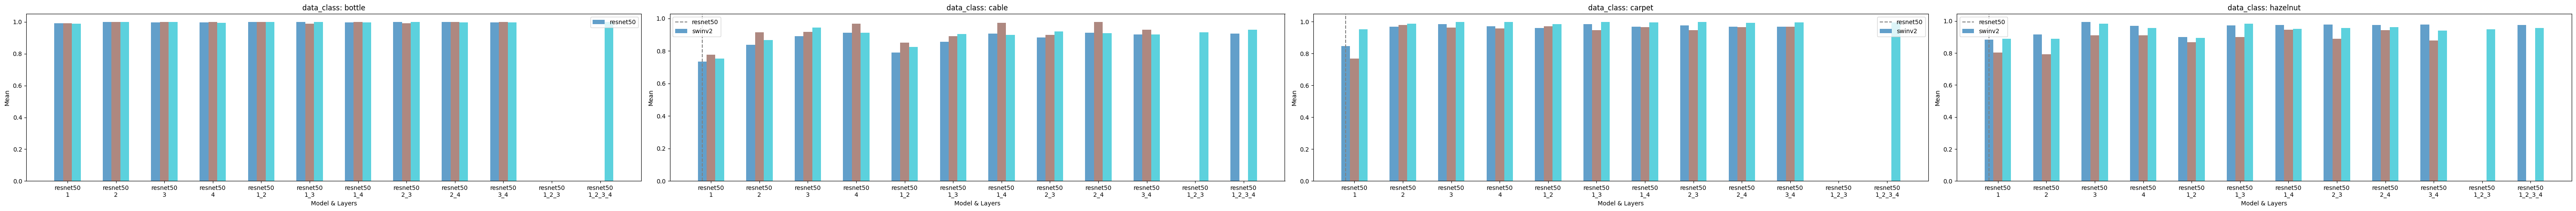

In [60]:
from matplotlib import cm

unique_data_classes = grouped_data['data_class_'].unique()
unique_models = grouped_data['model_'].unique()
unique_layers = grouped_data['layers_'].unique()
unique_layers_sorted = sorted(unique_layers, key=lambda x: (len(x.split('_')), x))

# モデルごとの色を準備
colors = cm.get_cmap('tab10', len(unique_models))

# 描画の準備
fig, ax = plt.subplots(1, len(unique_data_classes), figsize=(15 * len(unique_data_classes), 5))

# 各 data_class について描画
for i, data_class in enumerate(unique_data_classes):
    subset = grouped_data[grouped_data['data_class_'] == data_class]
    heights = []
    labels = []
    bar_positions = []
    bar_width = 0.2
    space_between_groups = 0.5
    current_position = 0
    
    for layer in unique_layers_sorted:
        for j, model in enumerate(unique_models):
            value = subset[(subset['model_'] == model) & (subset['layers_'] == layer)]['image_ROC_mean'].values
            if len(value) > 0:
                heights.append(value[0])
            else:
                heights.append(0)
            labels.append(f'{model}\n{layer}')
            bar_positions.append(current_position + j * bar_width)
        current_position += len(unique_models) * bar_width + space_between_groups

    # グラフの色を設定
    color_list = [colors(j) for j in range(len(unique_models))] * len(unique_layers_sorted)
    
    # image_ROC_mean の棒グラフを描画
    ax[i].bar(bar_positions, heights, color=color_list, alpha=0.7, width=bar_width, label='image_ROC_mean')
    
    # タイトル、ラベル、目盛りの設定
    ax[i].set_title(f'data_class: {data_class}')
    ax[i].set_xlabel('Model & Layers')
    ax[i].set_ylabel('Mean')
    ax[i].set_xticks([x + (bar_width * (len(unique_models) - 1)) / 2 for x in bar_positions[::len(unique_models)]])
    ax[i].set_xticklabels(labels[::len(unique_models)], rotation=0)
    
    # data_class が切り替わる部分に縦線を追加
    if i > 0:
        ax[i].axvline(x=0, color='grey', linestyle='--')

    ax[i].legend(unique_models)

# グラフの表示
plt.tight_layout()
plt.show()

/tmp/ipykernel_154005/1953588273.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


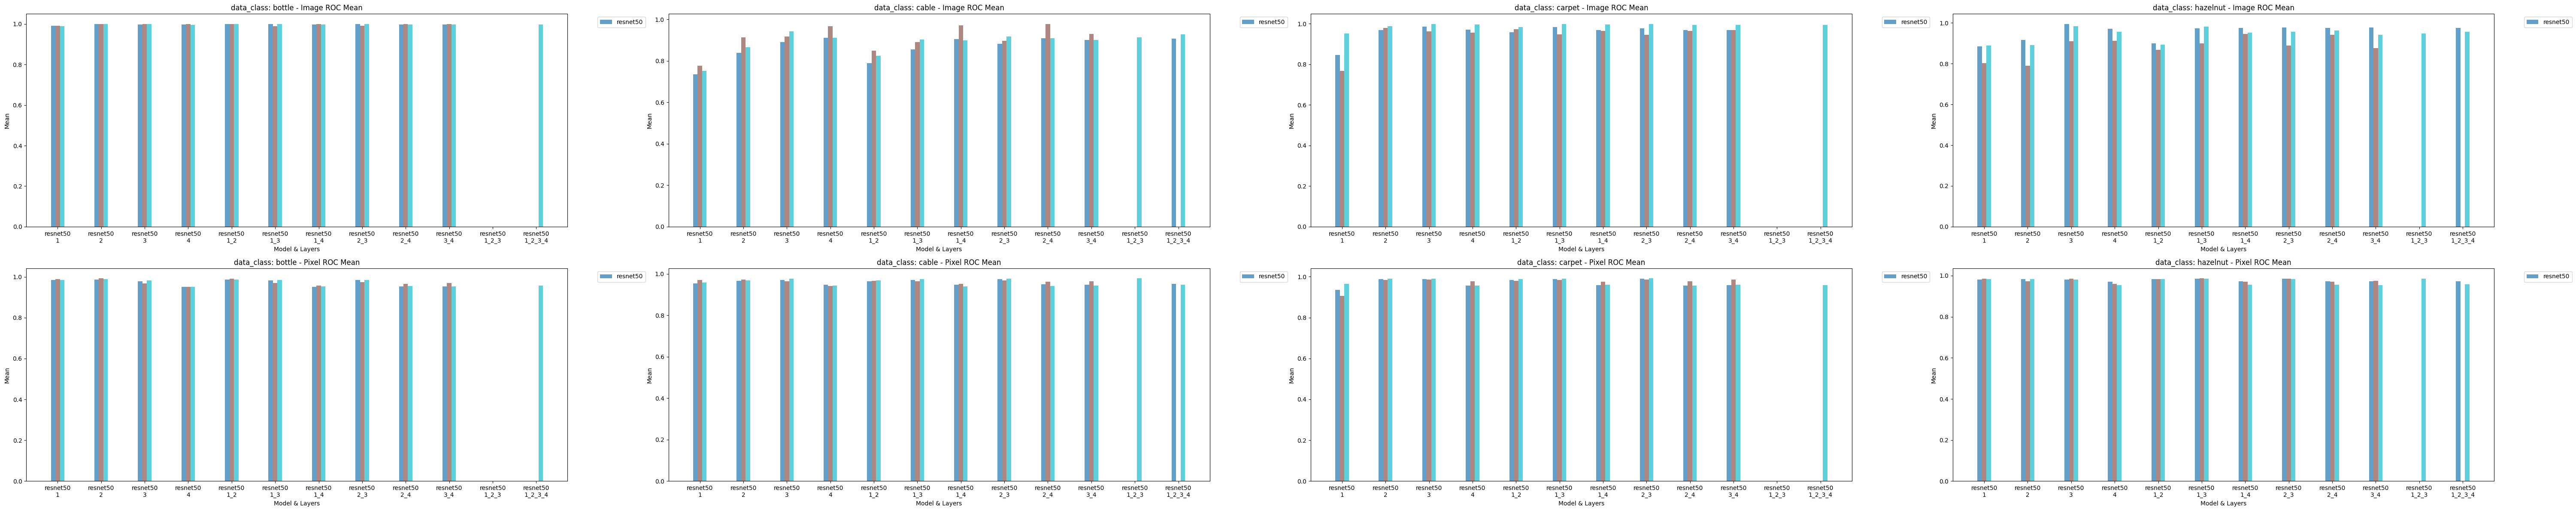

In [59]:
# 描画の準備
fig, ax = plt.subplots(2, len(unique_data_classes), figsize=(15 * len(unique_data_classes), 12), constrained_layout=True)

# 各 data_class について描画
for i, data_class in enumerate(unique_data_classes):
    for metric_idx, (metric, metric_title) in enumerate(metrics_and_titles):
        subset = grouped_data[grouped_data['data_class_'] == data_class]
        heights = []
        labels = []
        bar_positions = []
        bar_width = 0.15
        space_between_groups = 1.0
        current_position = 0

        for layer in unique_layers_sorted:
            for j, model in enumerate(unique_models):
                value = subset[(subset['model_'] == model) & (subset['layers_'] == layer)][metric].values
                if len(value) > 0:
                    heights.append(value[0])
                else:
                    heights.append(0)
                labels.append(f'{model}\n{layer}')
                bar_positions.append(current_position + j * bar_width)
            current_position += len(unique_models) * bar_width + space_between_groups

        # グラフの色を設定
        color_list = [colors(j) for j in range(len(unique_models))] * len(unique_layers_sorted)
        
        # 指定した metric の棒グラフを描画
        ax[metric_idx, i].bar(bar_positions, heights, color=color_list, alpha=0.7, width=bar_width)
        
        # タイトル、ラベル、目盛りの設定
        ax[metric_idx, i].set_title(f'data_class: {data_class} - {metric_title}')
        ax[metric_idx, i].set_xlabel('Model & Layers')
        ax[metric_idx, i].set_ylabel('Mean')
        ax[metric_idx, i].set_xticks([x + (bar_width * (len(unique_models) - 1)) / 2 for x in bar_positions[::len(unique_models)]])
        ax[metric_idx, i].set_xticklabels(labels[::len(unique_models)], rotation=0)
        ax[metric_idx, i].legend(unique_models, bbox_to_anchor=(1.05, 1), loc='upper left')

# グラフの表示
plt.tight_layout()
plt.show()
